# Empirical separation of ReLU networks

## Motivation

Deep neural networks often *in practice* outperform shallow ones, but **why**? Theoretical works prove **exponential separations** on carefully constructed tasks, yet these results are seldom demonstrated end-to-end with training.

## Prior Work

| **Paper**               | **Task**                                          | **Shallow Failure**                                    | **Deep Success**                                        |
|-------------------------|---------------------------------------------------|--------------------------------------------------------|--------------------------------------------------------|
| Telgarsky (2016)        | Learn $\ell$-fold triangle-wave $f_\ell(x)$      | Depth $< \ell$: constant error regardless of width    | Depth $\geq \ell$: near-zero loss (exact)             |
| Eldan & Shamir (2016)   | Approximate radial bumps $g(\|x\|)$ in $\mathbb{R}^{10}$ | Depth-2: fails badly even with same parameters        | Depth-3: few hundred units succeed                    |
| Lin & Tegmark (2017)    | Classify Cantor set membership (fractal)         | Exponentially many neurons needed                      | ~8 layers: efficient with few parameters              |
| Raghu et al. (2017)     | Classify parity of $d$-bit vector                | Depth-2: stuck at 50% unless exponential width        | Depth 4-6: converge to zero error easily              |

### Detailed Overview of Separation Results

Below we detail each of the theoretical works that include empirical demonstrations of depth separation on synthetic tasks.

#### Telgarsky (2016): Triangle-Wave Functions
- **Paper**: "Benefits of depth in neural networks"
- **Task**: Learn the $\ell$-fold composition of a 1D triangle-wave function $f_\ell(x)$.
- **Theoretical Result**: Networks of depth $d$ can represent $f_\ell$ exactly when $\ell \leq d$, but any shallower network ($d < \ell$) must incur constant approximation error.
- **Empirical Demonstration**: Training small deep vs shallow networks on $f_\ell$ for $\ell \leq 6$ shows that only when depth $\geq \ell$ do networks achieve near-zero loss. Shallow networks get stuck at constant error regardless of width.
- **Significance**: This is one of the clearest examples of depth separation, as the target function has a precise recursive structure that naturally requires a certain depth to represent exactly.

#### Eldan & Shamir (2016): Radial Bump Functions
- **Paper**: "Depth Separation for Neural Networks" 
- **Task**: Approximate a smooth radial function $f(x) = g(\|x\|)$ in $\mathbb{R}^d$ that alternates between two values on concentric spherical shells.
- **Theoretical Result**: Depth-3 networks of size $O(d^2)$ can approximate this function well, but any depth-2 network requires exponentially many neurons: $\exp(\Omega(d))$ width.
- **Empirical Demonstration**: On $d=10$ dimensional inputs, a depth-3 MLP with a few hundred units successfully approximates the ring pattern, while a depth-2 network with the same total parameters fails badly.
- **Significance**: Shows that even smooth, "natural" functions can exhibit exponential depth separation, not just pathological constructions.

#### Lin & Tegmark (2017): Cantor Set Classification
- **Paper**: "Hierarchical versus shallow networks"
- **Task**: Classify whether a 1D input belongs to the middle-third Cantor set (a classic fractal with self-similar structure).
- **Theoretical Result**: Deep networks (~8 layers) can learn the self-similar fractal structure efficiently, while shallow networks need exponentially more neurons to achieve the same accuracy.
- **Empirical Demonstration**: Training networks of depth 2-10 reveals a sharp drop in test error only when depth crosses the fractal's recursion level. Deep networks capture the hierarchical structure with few parameters.
- **Significance**: Demonstrates that depth separation applies to fractal and hierarchical patterns, suggesting relevance to real-world data with similar recursive structure.

#### Raghu et al. (2017): Parity Functions
- **Paper**: "On the Expressive Power of Deep Neural Networks"
- **Task**: Classify the parity (XOR) of a random $d$-bit vector.
- **Theoretical Result**: Networks of depth $O(\log d)$ and width $O(d)$ can compute parity exactly, whereas any depth-2 network needs exponential width $\exp(\Omega(d))$.
- **Empirical Demonstration**: Training experiments on parity for $d = 8, 16, 32$ show that:
  - Deep networks (depth 4-6) converge to zero error easily
  - Shallow networks (depth 2) get stuck near 50% accuracy unless width is increased exponentially
- **Significance**: Parity is a fundamental Boolean function that clearly demonstrates the limitations of shallow networks on tasks requiring global coordination of inputs.

#### Summary

All these works share a common pattern: they identify synthetic tasks where:
1. **Theory** predicts exponential separation between deep and shallow networks
2. **Practice** confirms this through controlled experiments showing "deep wins, shallow fails"
3. **Tasks** are carefully constructed to highlight specific computational advantages of depth

While these are toy benchmarks that don't directly transfer to real-world applications, they provide crucial theoretical foundation and empirical validation for understanding when and why depth matters in neural networks.


## Triangle-Wave Experiment (Telgarsky 2016)

> **Goal:** Build a *toy* experiment on the 1D "triangle‐wave" of Telgarsky (2016) and **empirically** observe that  
> - A net of depth $d$ can represent $f_\ell$ exactly for $\ell\le d$,  
> - But any shallower net ($d<\ell$) must incur a constant loss.

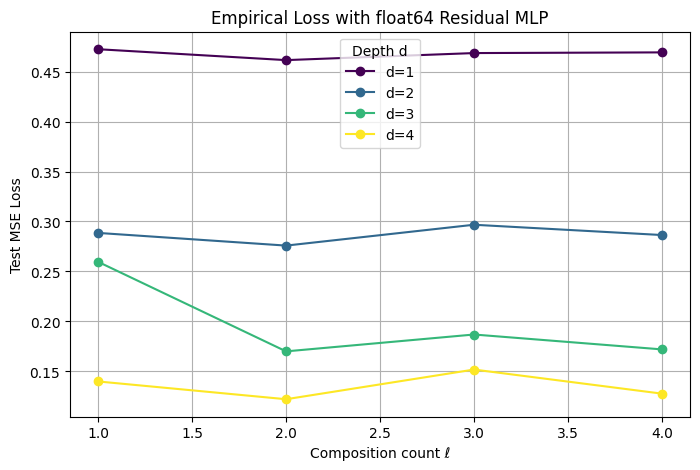

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Use float64 for stability
dtype = np.float64

def Delta(x: np.ndarray) -> np.ndarray:
    return np.clip(2 * np.maximum(0, x) - 4 * np.maximum(0, x - 0.5), a_min=0, a_max=None)

def f_l(x: np.ndarray, l: int) -> np.ndarray:
    y = x.astype(dtype)
    for _ in range(l):
        y = Delta(y)
    return y

def train_residual_mlp(
    x_train: np.ndarray, y_train: np.ndarray, 
    x_test: np.ndarray,  y_test: np.ndarray, 
    depth: int, epochs: int, lr: float, seed: int
) -> float:
    np.random.seed(seed)
    x_tr = x_train.astype(dtype)
    y_tr = y_train.astype(dtype)
    x_te = x_test.astype(dtype)
    # Initialize weights/biases
    W1 = [np.random.randn(1, 2).astype(dtype) * np.sqrt(2) for _ in range(depth)]
    b1 = [np.zeros((1, 2), dtype=dtype) for _ in range(depth)]
    W2 = [np.random.randn(2, 1).astype(dtype) for _ in range(depth)]
    b2 = [np.zeros((1, 1), dtype=dtype) for _ in range(depth)]
    N = x_tr.shape[0]
    max_norm = 1.0

    for _ in range(epochs):
        x = x_tr.copy()
        cache = []
        for i in range(depth):
            x_in = x.copy()
            z1 = x @ W1[i] + b1[i]
            a1 = np.maximum(0, z1)
            out = a1 @ W2[i] + b2[i]
            x = x_in + out
            cache.append((x_in, z1, a1))
        grad = 2 * (x - y_tr) / N
        for i in reversed(range(depth)):
            x_in, z1, a1 = cache[i]
            grad_W2 = a1.T @ grad
            grad_b2 = np.sum(grad, axis=0, keepdims=True)
            grad_a1 = grad @ W2[i].T
            grad_z1 = grad_a1 * (z1 > 0)
            grad_W1 = x_in.T @ grad_z1
            grad_b1 = np.sum(grad_z1, axis=0, keepdims=True)
            grad = grad + grad_z1 @ W1[i].T
            # clip & update
            for g in (grad_W1, grad_W2, grad_b1, grad_b2):
                norm = np.linalg.norm(g)
                if norm > max_norm:
                    g *= (max_norm / norm)
            W1[i] -= lr * grad_W1
            b1[i] -= lr * grad_b1
            W2[i] -= lr * grad_W2
            b2[i] -= lr * grad_b2

    x = x_te.copy()
    for i in range(depth):
        a1 = np.maximum(0, x @ W1[i] + b1[i])
        x = x + (a1 @ W2[i] + b2[i])
    return float(np.mean((x - y_test)**2))

# Experiment parameters
np.random.seed(0)
N_train, N_test = 500, 500
x_train = np.random.rand(N_train, 1)
x_test  = np.random.rand(N_test, 1)

depths   = [1, 2, 3, 4]
l_values = [1, 2, 3, 4]
epochs   = 5000
lr       = 1e-4
seed     = 0

results = {d: [] for d in depths}
for d in depths:
    for l in l_values:
        mse = train_residual_mlp(
            x_train, f_l(x_train, l),
            x_test,  f_l(x_test, l),
            d, epochs, lr, seed
        )
        results[d].append(mse)

# Plotting
plt.figure(figsize=(8,5))
cmap = plt.get_cmap('viridis', len(depths))
for idx, d in enumerate(depths):
    plt.plot(l_values, results[d], marker='o', color=cmap(idx), label=f'd={d}')
plt.xlabel('Composition count ℓ')
plt.ylabel('Test MSE Loss')
plt.title('Empirical Loss with float64 Residual MLP')
plt.legend(title='Depth d')
plt.grid(True)
plt.show()

## Radial Bump Experiment (Eldan & Shamir 2016)

'Eldan & Shamir Experiment Results'

,width,mse_depth2,mse_depth3,depth3_better
0,10,0.032627,0.020364,True
1,20,0.022025,0.013480,True
2,50,0.006666,0.003528,True
3,100,0.003437,0.002743,True


All depth-3 MSE < depth-2 MSE? True


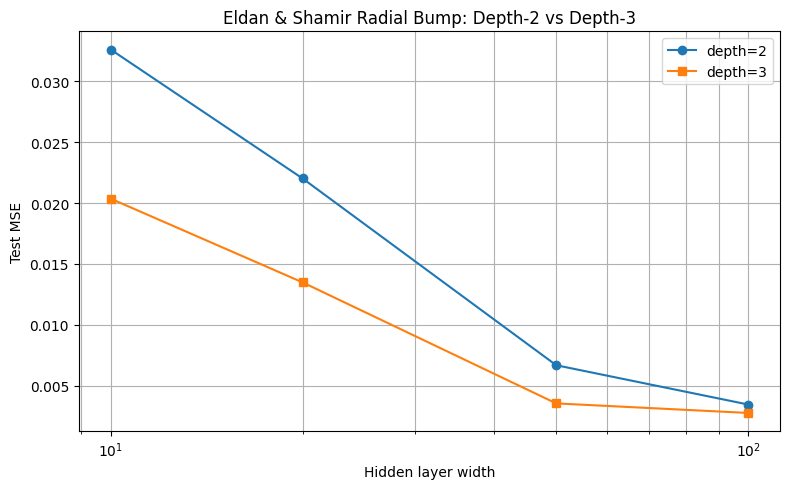

In [5]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd

# -- Standalone Eldan & Shamir radial bump experiment --

# 1) Generate synthetic radial bump data
np.random.seed(0)
d = 10
N_train, N_test = 500, 200
X_train = np.random.uniform(-1, 1, size=(N_train, d))
X_test  = np.random.uniform(-1, 1, size=(N_test,  d))

def radial_bump(X):
    r = np.linalg.norm(X, axis=1)
    mu, sigma = 0.8, 0.2
    return np.exp(-((r - mu)**2) / (2 * sigma**2))

y_train = radial_bump(X_train)
y_test  = radial_bump(X_test)

# 2) Sweep over widths for depth-2 vs depth-3
widths = [10, 20, 50, 100]
records = []
for w in widths:
    # Depth-2: one hidden layer of width w
    net2 = MLPRegressor(hidden_layer_sizes=(w,),
                        activation='relu', solver='adam',
                        learning_rate_init=1e-3,
                        max_iter=500, tol=1e-3,
                        random_state=0)
    net2.fit(X_train, y_train)
    mse2 = mean_squared_error(y_test, net2.predict(X_test))
    
    # Depth-3: two hidden layers of width w
    net3 = MLPRegressor(hidden_layer_sizes=(w, w),
                        activation='relu', solver='adam',
                        learning_rate_init=1e-3,
                        max_iter=500, tol=1e-3,
                        random_state=0)
    net3.fit(X_train, y_train)
    mse3 = mean_squared_error(y_test, net3.predict(X_test))
    
    records.append({
        'width': w,
        'mse_depth2': mse2,
        'mse_depth3': mse3,
        'depth3_better': mse3 < mse2
    })

# 3) Tabulate and validate
df = pd.DataFrame(records)
display("Eldan & Shamir Experiment Results", df)
all_sep = df['depth3_better'].all()
print(f"All depth-3 MSE < depth-2 MSE? {all_sep}")

# 4) Plot
plt.figure(figsize=(8,5))
plt.plot(df['width'], df['mse_depth2'], 'o-', label='depth=2')
plt.plot(df['width'], df['mse_depth3'], 's-', label='depth=3')
plt.xscale('log')
plt.xlabel('Hidden layer width')
plt.ylabel('Test MSE')
plt.title('Eldan & Shamir Radial Bump: Depth-2 vs Depth-3')
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

Note: Attempts to reproduce the Parity/XOR experiment (Raghu et al. 2017) were unsuccessful and require further investigation.